# Intelligent App with Google Generative AI and Neo4j
In this notebook, let's explore how to leverage Google GenAI to build and consume a knowledge graph in Neo4j.

This notebook parses data from a public [corpus of Resumes / Curriculum Vitae](https://github.com/florex/resume_corpus) using Google Vertex AI Generative AI's `text-bison` model. The model will be prompted to recognise and extract entities and relationships. We will then generate Neo4j Cypher queries using them and write the data to a Neo4j database.
We will again use a `text-bison` model and prompt it to convert questions in english to Cypher - Neo4j's query language, which can be used for data retrieval.

## Setup
First off, check that the Python environment you installed in the readme is running this notebook. Make sure you select the `py38` kernel in the top right of this notebook. You should see a 3.8 version when you run this command.

In [1]:
import sys
sys.version

'3.8.16 | packaged by conda-forge | (default, Feb  1 2023, 16:01:55) \n[GCC 11.3.0]'

Next we need to install some libraries.

In [ ]:
%pip install --user "google-cloud-aiplatform>=1.25.0" --upgrade
%pip install --user "google-cloud-aiplatform[pipelines]>=1.25.0"
%pip install --user "langchain>=0.0.216"
%pip install --user neo4j
%pip install --user pydantic
%pip install --user gradio
%pip install --user IProgress
%pip install --user tqdm

Now restart the kernel.  That will allow the Python evironment to import the new packages.

Provide your `Project ID` (**NOT** Project Name) & `location` in the code below

In [1]:
# Note, you will need to set your project_id
project_id = 'neo4jbusinessdev'
location = 'us-central1'

In [2]:
import vertexai
vertexai.init(project=project_id, location=location)

## Prompt Definition

In the upcoming sections, we will extract knowledge adhering to the following schema. This is a very Simplified schema to denote a Resume. Normally, you will have Domain Experts who come up with an ideal Ontology.

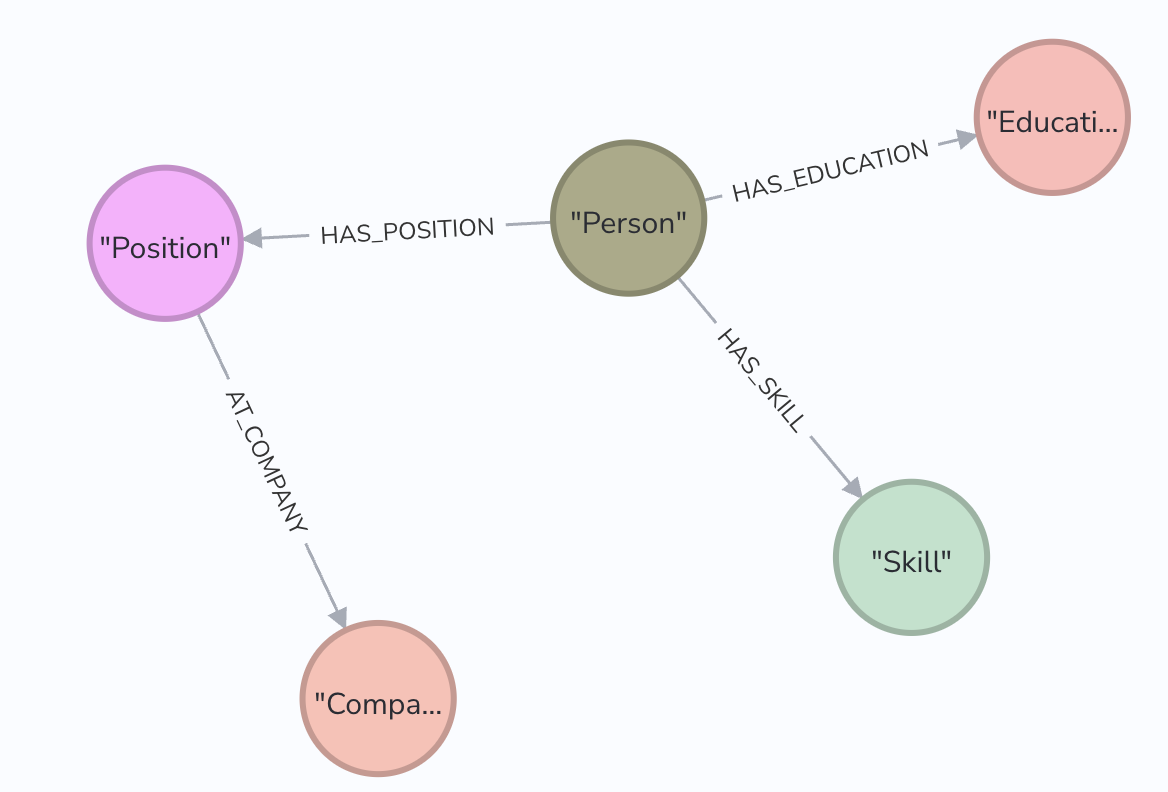

To achieve our Extraction goal as per the schema, I am going to chain a series of prompts, each focused on only one task - to extract a specific entity. By this way, you can avoid Token limitations. Also, the quality of extraction will be good.

In [3]:
person_prompt_tpl="""From the Resume text for a job aspirant below, extract Entities strictly as instructed below
1. First, look for the Person Entity type in the text and extract the needed information defined below:
   `id` property of each entity must be alphanumeric and must be unique among the entities. You will be referring this property to define the relationship between entities. NEVER create new entity types that aren't mentioned below. Document must be summarized and stored inside Person entity under `description` property
    Entity Types:
    label:'Person',id:string,role:string,description:string //Person Node
2. Description property should be a crisp text summary and MUST NOT be more than 100 characters
3. If you cannot find any information on the entities & relationships above, it is okay to return empty value. DO NOT create fictious data
4. Do NOT create duplicate entities
5. Restrict yourself to extract only Person information. No Position, Company, Education or Skill information should be focussed.
6. NEVER Impute missing values
Example Output JSON:
{"entities": [{"label":"Person","id":"person1","role":"Prompt Developer","description":"Prompt Developer with more than 30 years of LLM experience"}]}

Question: Now, extract the Person for the text below -
$ctext

Answer:
"""

In [4]:
postion_prompt_tpl="""From the Resume text for a job aspirant below, extract Entities & relationships strictly as instructed below
1. First, look for Position & Company types in the text and extract information in comma-separated format. Position Entity denotes the Person's previous or current job. Company node is the Company where they held that position.
   `id` property of each entity must be alphanumeric and must be unique among the entities. You will be referring this property to define the relationship between entities. NEVER create new entity types that aren't mentioned below. You will have to generate as many entities as needed as per the types below:
    Entity Types:
    label:'Position',id:string,title:string,location:string,startDate:string,endDate:string,url:string //Position Node
    label:'Company',id:string,name:string //Company Node
2. Next generate each relationships as triples of head, relationship and tail. To refer the head and tail entity, use their respective `id` property. NEVER create new Relationship types that aren't mentioned below:
    Relationship definition:
    position|AT_COMPANY|company //Ensure this is a string in the generated output
3. If you cannot find any information on the entities & relationships above, it is okay to return empty value. DO NOT create fictious data
4. Do NOT create duplicate entities. 
5. No Education or Skill information should be extracted.
6. DO NOT MISS out any Position or Company related information
7. NEVER Impute missing values
 Example Output JSON:
{"entities": [{"label":"Position","id":"position1","title":"Software Engineer","location":"Singapore",startDate:"2021-01-01",endDate:"present"},{"label":"Position","id":"position2","title":"Senior Software Engineer","location":"Mars",startDate:"2020-01-01",endDate:"2020-12-31"},{label:"Company",id:"company1",name:"Neo4j Singapore Pte Ltd"},{"label":"Company","id":"company2","name":"Neo4j Mars Inc"}],"relationships": ["position1|AT_COMPANY|company1","position2|AT_COMPANY|company2"]}

Question: Now, extract entities & relationships as mentioned above for the text below -
$ctext

Answer:
"""

In [5]:
skill_prompt_tpl="""From the Resume text below, extract Entities strictly as instructed below
1. Look for prominent Skill Entities in the text. The`id` property of each entity must be alphanumeric and must be unique among the entities. NEVER create new entity types that aren't mentioned below:
    Entity Definition:
    label:'Skill',id:string,name:string,level:string //Skill Node
2. NEVER Impute missing values
3. If you do not find any level information: assume it as `expert` if the experience in that skill is more than 5 years, `intermediate` for 2-5 years and `beginner` otherwise.
Example Output Format:
{"entities": [{"label":"Skill","id":"skill1","name":"Neo4j","level":"expert"},{"label":"Skill","id":"skill2","name":"Pytorch","level":"expert"}]}

Question: Now, extract entities as mentioned above for the text below -
$ctext

Answer:
"""

In [6]:
edu_prompt_tpl="""From the Resume text for a job aspirant below, extract Entities strictly as instructed below
1. Look for Education entity type and generate the information defined below:
   `id` property of each entity must be alphanumeric and must be unique among the entities. You will be referring this property to define the relationship between entities. NEVER create other entity types that aren't mentioned below. You will have to generate as many entities as needed as per the types below:
    Entity Definition:
    label:'Education',id:string,degree:string,university:string,graduationDate:string,score:string,url:string //Education Node
2. If you cannot find any information on the entities above, it is okay to return empty value. DO NOT create fictious data
3. Do NOT create duplicate entities or properties
4. Strictly extract only Education. No Skill or other Entities should be extracted
5. DO NOT MISS out any Education related entity
6. NEVER Impute missing values
Output JSON (Strict):
{"entities": [{"label":"Education","id":"education1","degree":"Bachelor of Science","graduationDate":"May 2022","score":"0.0"}]}

Question: Now, extract Education information as mentioned above for the text below -
$ctext

Answer:
"""

This is a helper function to talk to the LLM with our prompt and text input. We will use the `text-bison` base model. In your usecase, you might need to tune it. VertexAI provides an elegant way to finetune it. The weights will be staying within your tenant and the base model is frozen.

In [7]:
from vertexai.preview.language_models import TextGenerationModel

def run_text_model(
    project_id: str,
    model_name: str,
    temperature: float,
    max_decode_steps: int,
    top_p: float,
    top_k: int,
    prompt: str,
    location: str = location,
    tuned_model_name: str = "",
    ) :
    """Text Completion Use a Large Language Model."""
    vertexai.init(project=project_id, location=location)
    model = TextGenerationModel.from_pretrained(model_name)
    if tuned_model_name:
      model = model.get_tuned_model(tuned_model_name)
    response = model.predict(
        prompt,
        temperature=temperature,
        max_output_tokens=max_decode_steps,
        top_k=top_k,
        top_p=top_p,)
    return response.text

In [8]:
def extract_entities_relationships(prompt, tuned_model_name):
    try:
        res = run_text_model(project_id, "text-bison@001", 0, 1024, 0.8, 40, prompt, location, tuned_model_name)
        return res
    except Exception as e:
        print(e)
    

Now, let's run our extraction task

In [9]:
import re
def clean_text(text):
    return re.sub(r'[^\x00-\x7F]+',' ', text)

In [132]:
from string import Template
import json

sample_que = """Developer <span class="hl">Developer</span> Developer - TATA CONSULTANTCY SERVICE Batavia, OH Relevant course work† Database Systems, Database Administration, Database Security & Auditing, Computer Security,Computer Networks, Programming & Software Development, IT, Information Security Concept & Admin,† IT System Acquisition & Integration, Advanced Web Development, and Ethical Hacking: Network Security & Pen Testing. Work Experience Developer TATA CONSULTANTCY SERVICE June 2016 to Present MRM (Government of ME, RI, MS) Developer†††† Working with various technologies such as Java, JSP, JSF, DB2(SQL), LDAP, BIRT report, Jazz version control, Squirrel SQL client, Hibernate, CSS, Linux, and Windows. Work as part of a team that provide support to enterprise applications. Perform miscellaneous support activities as requested by Management. Perform in-depth research and identify sources of production issues.†† SPLUNK Developer† Supporting the Splunk Operational environment for Business Solutions Unit aiming to support overall business infrastructure. Developing Splunk Queries to generate the report, monitoring, and analyzing machine generated big data for server that has been using for onsite and offshore team. Working with Splunk' premium apps such as ITSI, creating services, KPI, and glass tables. Developing app with custom dashboard with front- end ability and advanced XML to serve Business Solution unit' needs. Had in-house app presented at Splunk's .Conf Conference (2016). Help planning, prioritizing and executing development activities. Developer ( front end) intern TOMORROW PICTURES INC - Atlanta, GA April 2015 to January 2016 Assist web development team with multiple front end web technologies and involved in web technologies such as Node.js, express, json, gulp.js, jade, sass, html5, css3, bootstrap, WordPress.†Testing (manually), version control (GitHub), mock up design and ideas Education MASTER OF SCIENCE IN INFORMATION TECHNOLOGY in INFOTMATION TECHNOLOGY KENNESAW STATE UNIVERSITY - Kennesaw, GA August 2012 to May 2015 MASTER OF BUSINESS ADMINISTRATION in INTERNATIONAL BUSINESS AMERICAN INTER CONTINENTAL UNIVERSITY ATLANTA November 2003 to December 2005 BACHELOR OF ARTS in PUBLIC RELATIONS THE UNIVERSITY OF THAI CHAMBER OF COMMERCE - BANGKOK, TH June 1997 to May 2001 Skills Db2 (2 years), front end (2 years), Java (2 years), Linux (2 years), Splunk (2 years), SQL (3 years) Certifications/Licenses Splunk Certified Power User V6.3 August 2016 to Present CERT-112626 Splunk Certified Power User V6.x May 2017 to Present CERT-168138 Splunk Certified User V6.x May 2017 to Present CERT -181476 Driver's License Additional Information Skills† ∑††††SQL, PL/SQL, Knowledge of Data Modeling, Experience on Oracle database/RDBMS.† ∑††††††††Database experience on Oracle, DB2, SQL Sever, MongoDB, and MySQL.† ∑††††††††Knowledge of tools including Splunk, tableau, and wireshark.† ∑††††††††Knowledge of SCRUM/AGILE and WATERFALL methodologies.† ∑††††††††Web technology included: HTML5, CSS3, XML, JSON, JavaScript, node.js, NPM, GIT, express.js, jQuery, Angular, Bootstrap, and Restful API.† ∑††††††††Working Knowledge in JAVA, J2EE, and PHP.† Operating system Experience included: Windows, Mac OS, Linux (Ubuntu, Mint, Kali)††"""
prompts = [person_prompt_tpl, postion_prompt_tpl, skill_prompt_tpl, edu_prompt_tpl]
results = {"entities": [], "relationships": []}

for p in prompts:
    _prompt = Template(p).substitute(ctext=clean_text(sample_que))
    _extraction = extract_entities_relationships(_prompt, '')
    if 'Answer:\n' in _extraction:
        _extraction = _extraction.split('Answer:\n ')[1]
    if _extraction.strip() == '':
        continue
    try:
        _extraction = json.loads(_extraction.replace("\'", "'").replace('`', ''))
    except json.JSONDecodeError:
        # print(_extraction)
        #Temp hack to ignore Skills cut off by token limitation
        _extraction = _extraction[:_extraction.rfind("}")+1] + ']}'
        _extraction = json.loads(_extraction.replace("\'", "'"))
    results["entities"].extend(_extraction["entities"])
    if "relationships" in _extraction:
        results["relationships"].extend(_extraction["relationships"])

In [133]:
person_id = results["entities"][0]["id"]
for e in results["entities"][1:]:
    if e['label'] == 'Position':
        results["relationships"].append(f"{person_id}|HAS_POSITION|{e['id']}")
    if e['label'] == 'Skill':
        results["relationships"].append(f"{person_id}|HAS_SKILL|{e['id']}")
    if e['label'] == 'Education':
        results["relationships"].append(f"{person_id}|HAS_EDUCATION|{e['id']}")

The extracted entities & relationships will look like this

In [134]:
results

{'entities': [{'label': 'Person',
   'id': 'person1',
   'role': 'Developer',
   'description': 'Developer with 10 years of experience in IT industry'},
  {'label': 'Position',
   'id': 'position1',
   'title': 'Developer',
   'location': 'Batavia, OH',
   'startDate': '2016-06-01',
   'endDate': 'present'},
  {'label': 'Company', 'id': 'company1', 'name': 'TATA CONSULTANTCY SERVICE'},
  {'label': 'Skill', 'id': 'skill1', 'name': 'SQL', 'level': 'expert'},
  {'label': 'Skill', 'id': 'skill2', 'name': 'Java', 'level': 'expert'},
  {'label': 'Skill', 'id': 'skill3', 'name': 'Linux', 'level': 'expert'},
  {'label': 'Skill', 'id': 'skill4', 'name': 'Splunk', 'level': 'expert'},
  {'label': 'Skill', 'id': 'skill5', 'name': 'front end', 'level': 'expert'},
  {'label': 'Skill', 'id': 'skill6', 'name': 'Db2', 'level': 'expert'},
  {'label': 'Skill', 'id': 'skill7', 'name': 'HTML5', 'level': 'intermediate'},
  {'label': 'Skill', 'id': 'skill8', 'name': 'CSS3', 'level': 'intermediate'},
  {'labe

## Data Ingestion Cypher Generation

The entities and relationships we got from the LLM have to be transformed to Cypher so we can write them into Neo4j.

In [35]:
import re

def get_prop_str(prop_dict, _id):
    s = []
    for key, val in prop_dict.items():
      if key != 'label' and key != 'id':
         s.append(_id+"."+key+' = "'+str(val).replace('\"', '"').replace('"', '\"')+'"') 
    return ' ON CREATE SET ' + ','.join(s)

def get_cypher_compliant_var(_id):
    s = "_"+ re.sub(r'[\W_]', '', _id).lower() #avoid numbers appearing as firstchar; replace spaces
    return s[:20] #restrict variable size

def generate_cypher(file_name, in_json):
    e_map = {}
    e_stmt = []
    r_stmt = []
    e_stmt_tpl = Template("($id:$label{id:'$key'})")
    r_stmt_tpl = Template("""
      MATCH $src
      MATCH $tgt
      MERGE ($src_id)-[:$rel]->($tgt_id)
    """)
    for obj in in_json:
      for j in obj['entities']:
          props = ''
          label = j['label']
          id = ''
          if label == 'Person':
            id = 'p'+str(file_name)
          elif label == 'Position':
            c = j['id'].replace('position', '_')
            id = f'j{str(file_name)}{c}'
          elif label == 'Education':
            c = j['id'].replace('education', '_')
            id = f'e{str(file_name)}{c}'
          else:
            id = get_cypher_compliant_var(j['name'])
          if label in ['Person', 'Position', 'Education', 'Skill', 'Company']:
            varname = get_cypher_compliant_var(j['id'])
            stmt = e_stmt_tpl.substitute(id=varname, label=label, key=id)
            e_map[varname] = stmt
            e_stmt.append('MERGE '+ stmt + get_prop_str(j, varname))

      for st in obj['relationships']:
          rels = st.split("|")
          src_id = get_cypher_compliant_var(rels[0].strip())
          rel = rels[1].strip()
          if rel in ['HAS_SKILL', 'HAS_EDUCATION', 'AT_COMPANY', 'HAS_POSITION']: #we ignore other relationships
            tgt_id = get_cypher_compliant_var(rels[2].strip())
            stmt = r_stmt_tpl.substitute(
              src_id=src_id, tgt_id=tgt_id, src=e_map[src_id], tgt=e_map[tgt_id], rel=rel)
            r_stmt.append(stmt)

    return e_stmt, r_stmt

In [136]:
ent_cyp, rel_cyp = generate_cypher('my_cv', [results])

print(ent_cyp, rel_cyp)

['MERGE (_person1:Person{id:\'p1686553861478559049\'}) ON CREATE SET _person1.role = "Developer",_person1.description = "Developer with 10 years of experience in IT industry"', 'MERGE (_position1:Position{id:\'j1686553861478592523\'}) ON CREATE SET _position1.title = "Developer",_position1.location = "Batavia, OH",_position1.startDate = "2016-06-01",_position1.endDate = "present"', 'MERGE (_company1:Company{id:\'_tataconsultantcyser\'}) ON CREATE SET _company1.name = "TATA CONSULTANTCY SERVICE"', 'MERGE (_skill1:Skill{id:\'_sql\'}) ON CREATE SET _skill1.name = "SQL",_skill1.level = "expert"', 'MERGE (_skill2:Skill{id:\'_java\'}) ON CREATE SET _skill2.name = "Java",_skill2.level = "expert"', 'MERGE (_skill3:Skill{id:\'_linux\'}) ON CREATE SET _skill3.name = "Linux",_skill3.level = "expert"', 'MERGE (_skill4:Skill{id:\'_splunk\'}) ON CREATE SET _skill4.name = "Splunk",_skill4.level = "expert"', 'MERGE (_skill5:Skill{id:\'_frontend\'}) ON CREATE SET _skill5.name = "front end",_skill5.leve

## Data Ingestion

You will need a Neo4j AuraDS Pro instance.  You can deploy that on Google Cloud Marketplace [here](https://console.cloud.google.com/marketplace/product/endpoints/prod.n4gcp.neo4j.io).

With that complete, you'll need to install the Neo4j library and set up your database connection.

In [3]:
from neo4j import GraphDatabase

In [4]:
import getpass

# You will need to change these variables
connectionUrl = input("Neo4j Connection URL")
username = input("DB Username")
password = getpass.getpass("DB password")

Neo4j Connection URL neo4j+s://eb79ec09.databases.neo4j.io
DB Username neo4j
DB password ········


In [5]:
driver = GraphDatabase.driver(connectionUrl, auth=(username, password))
driver.verify_connectivity()

In [6]:
import pandas as pd
def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

Before loading the data, create constraints as below

In [32]:
run_query('CREATE CONSTRAINT unique_person_id IF NOT EXISTS FOR (n:Person) REQUIRE (n.id) IS UNIQUE')
run_query('CREATE CONSTRAINT unique_position_id IF NOT EXISTS FOR (n:Position) REQUIRE (n.id) IS UNIQUE')
run_query('CREATE CONSTRAINT unique_skill_id IF NOT EXISTS FOR (n:Skill) REQUIRE n.id IS UNIQUE')
run_query('CREATE CONSTRAINT unique_education_id IF NOT EXISTS FOR (n:Education) REQUIRE n.id IS UNIQUE')
run_query('CREATE CONSTRAINT unique_company_id IF NOT EXISTS FOR (n:Company) REQUIRE n.id IS UNIQUE')

""


Ingest the entities

In [19]:
%%time
for e in ent_cyp:
    run_query(e)

CPU times: user 1.96 s, sys: 68.6 ms, total: 2.02 s
Wall time: 1min 43s


Ingest relationships now

In [21]:
%%time
for r in rel_cyp:
    run_query(r)

CPU times: user 1.85 s, sys: 101 ms, total: 1.96 s
Wall time: 1min 40s


Your ingested data from the above commands might look like this:

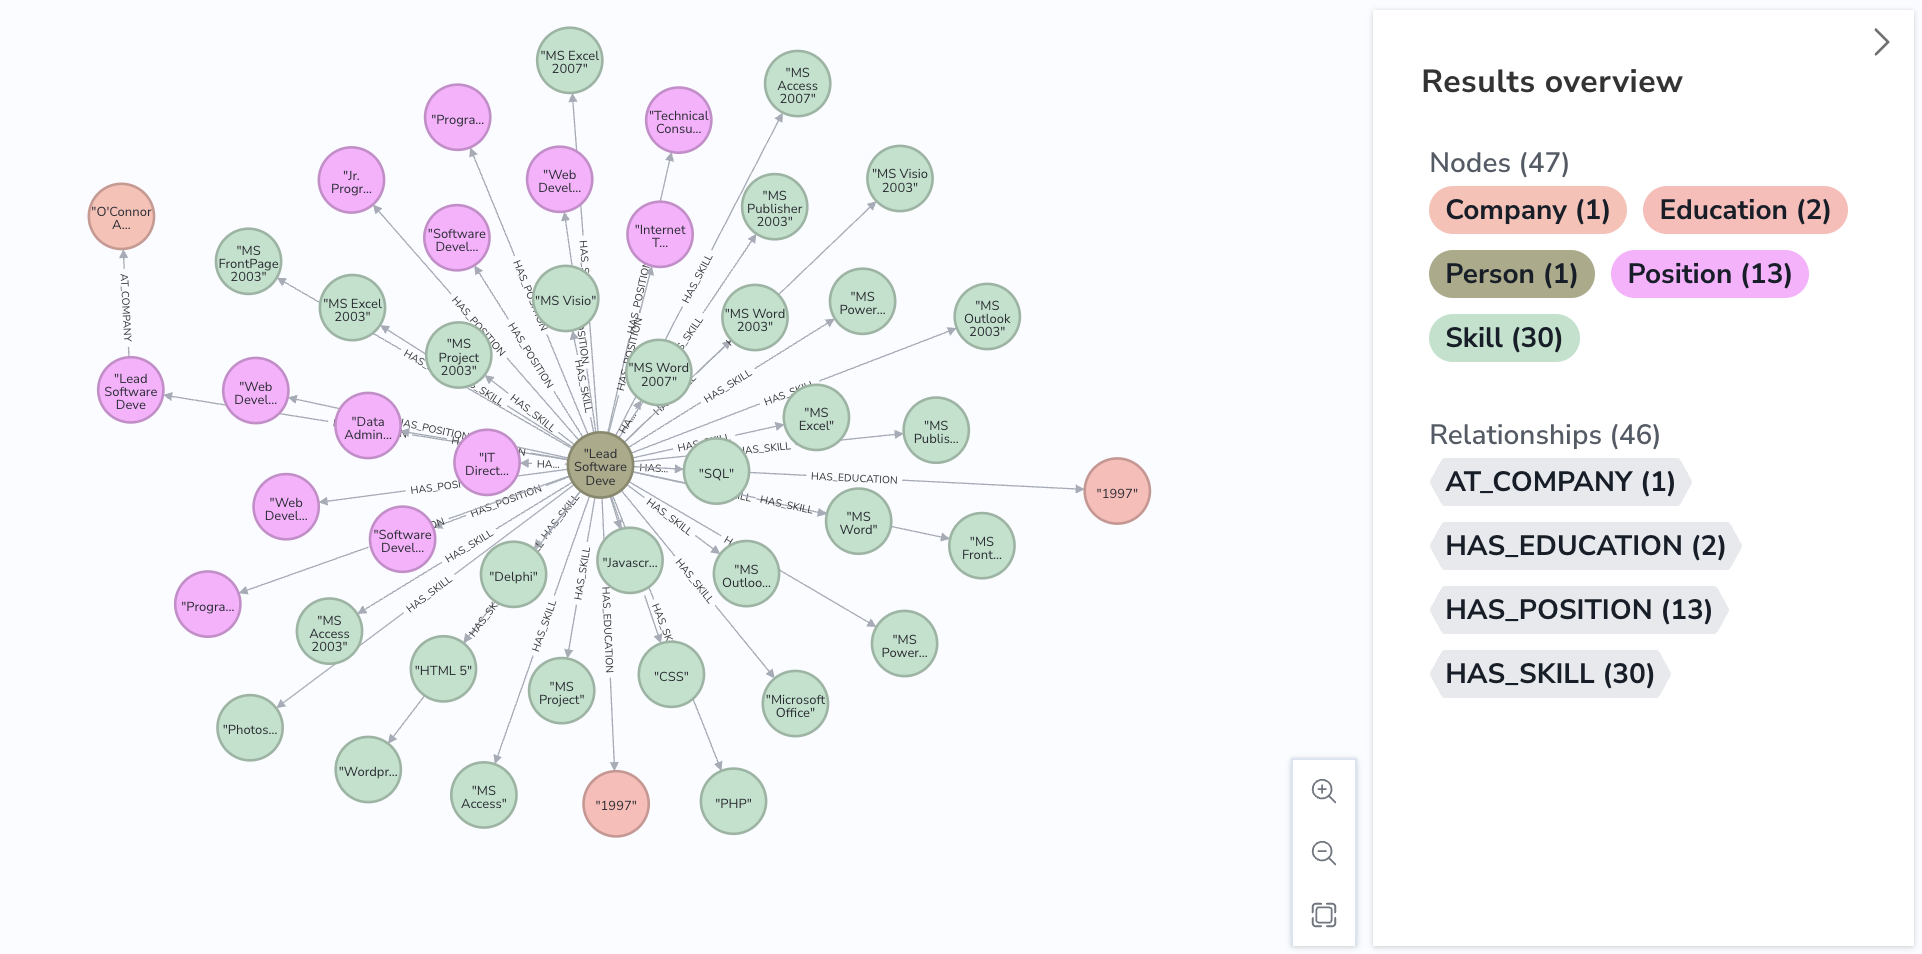

We got thousands of Resumes in the `data` directory. Let us run a pipeline to ingest only a few of them now. 

In [29]:
import glob
from string import Template
import json
from pathlib import Path

def run_pipeline(start=0, count=1):
    txt_files = glob.glob("data/*.txt")[start:count]
    print(f"Running pipeline for {len(txt_files)} files")
    failed_files = process_pipeline(txt_files)
    print(failed_files)
    return failed_files

def process_pipeline(files):
    failed_files = []
    i = 0
    for f in files:
        i += 1
        try:
            with open(f, 'r', encoding='utf-8', errors='ignore') as file:
                print(f"  {f}: Reading File No. ({i})")
                data = file.read().rstrip()
                text = data
                print(f"    {f}: Extracting Entities & Relationships")
                results = run_extraction(f, text)
                print(f"    {f}: Generating Cypher")
                ent_cyp, rel_cyp = generate_cypher(Path(f).stem, results)
                print(f"    {f}: Ingesting Entities")
                for e in ent_cyp:
                    run_query(e)
                print(f"    {f}: Ingesting Relationships")
                for r in rel_cyp:
                    run_query(r)
                print(f"    {f}: Processing DONE")
        except Exception as e:
            print(f"    {f}: Processing Failed with exception {e}")
            failed_files.append(f)
    return failed_files
        
from timeit import default_timer as timer
def run_extraction(f, text):
    start = timer()
    prompts = [person_prompt_tpl, postion_prompt_tpl, skill_prompt_tpl, edu_prompt_tpl]
    results = {"entities": [], "relationships": []}
    for p in prompts:
        _prompt = Template(p).substitute(ctext=text)
        _extraction = extract_entities_relationships(_prompt, '')
        if 'Answer:\n' in _extraction:
            _extraction = _extraction.split('Answer:\n ')[1]
        if _extraction.strip() == '':
            continue
        try:
            _extraction = json.loads(_extraction.replace("\'", "'"))
        except json.JSONDecodeError:
            #Temp hack to ignore Skills cut off by token limitation
            _extraction = _extraction[:_extraction.rfind("}")+1] + ']}'
            _extraction = json.loads(_extraction.replace("\'", "'"))
        results["entities"].extend(_extraction["entities"])
        if "relationships" in _extraction:
            results["relationships"].extend(_extraction["relationships"])
    person_id = results["entities"][0]["id"]
    for e in results["entities"][1:]:
        if e['label'] == 'Position':
            results["relationships"].append(f"{person_id}|HAS_POSITION|{e['id']}")
        if e['label'] == 'Skill':
            results["relationships"].append(f"{person_id}|HAS_SKILL|{e['id']}")
        if e['label'] == 'Education':
            results["relationships"].append(f"{person_id}|HAS_EDUCATION|{e['id']}")
    end = timer()
    elapsed = (end-start)
    print(f"    {f}: Entity Extraction took {elapsed}secs")
    return [results]

Lets run the pipeline only for the first 100 files. This will only process those 10 files and ingested them to Neo4j. It usually takes around 30-45 minutes for 100 files. 

In your case, you may need to run the pipeline for 1000s of files inside the `data` folder.

In [ ]:
%%capture output
%%time
failed_files = run_pipeline(0, 100) # runs ingestion pipeline for files from index 0 to 100

If processing failed for some files due to API Rate limit, you can retry as below. For token limitation error, it is better to chunk the text and retry.

In [ ]:
output.show()

In [ ]:
%%time
failed_files = process_pipeline(failed_files)
failed_files

## Cypher Generation for Consumption

### Tune the model to generate Cypher (OPTIONAL)

The Codey family of models perform well for Cypher generation with few-shot prompting. However, they are not tunable at the moment. If you need to tune a model for specific Cypher Generation task, you can consider `text-bison` model we used during the ingestion process above. So, the tuning section below is completely optional.


The `text-bison` base model can be tuned to generate more accurate Cypher. Lets see how to adapter tune it. We will try to tune the model with some Cypher statements. The model achieves some Cypher generation capability but could be better. It is suggested to try with at least a few hundred statements. You should aim for more quality training data. 

The total training time below takes more than an hour. The tuned adapter model is going to stay within your tenant and your training data will not be used to train the base model which is frozen. Tuning runs on GCP's TPU infrastructure that is optimised to run ML workloads.

First, let us upload our training set in `jsonl` format to a GCS bucket. We will use this file `finetuning/eng-to-cypher-trng.jsonl` for our fine-tuning. You can take a look over the data there.

VertexAI expects you to adhere to this format for each line of the `jsonl` file. 
```json
{"input_text": "MY_INPUT_PROMPT", "output_text": "CYPHER_QUERY"} 
```

When you got some changes in the training data, ensure that you upload the updated file in a different name than your previous tuning exercises. Because Vertex AI caches data uploaded previously, it skips any file validation and uses the previously uploaded data.

In [27]:
from google.cloud import storage
from timeit import default_timer as timer

bucket_name = project_id + '-genai'
client = storage.Client()
try:
    bucket = client.get_bucket(bucket_name)
except:
    bucket = client.bucket(bucket_name)
    bucket.storage_class = 'STANDARD'
    bucket = client.create_bucket(bucket)

upload_name = f"finetuning/eng-to-cypher-trng-{timer()}.jsonl" #this ensures vertexai reloads the file
filename = 'finetuning/eng-to-cypher-trng.jsonl'
blob = bucket.blob(upload_name)
blob.upload_from_filename(filename)

Let's tune the model for a hundred training steps. When you the below code, the following sequence happens:
1. Pipeline Validation
2. Dataset Export
3. Prompt Validation
4. jsonl to tfrecord conversion
5. Parameter Composition for Adapter tuning
6. LLM Tuning
7. Model uploading and
8. Endpoint deployment

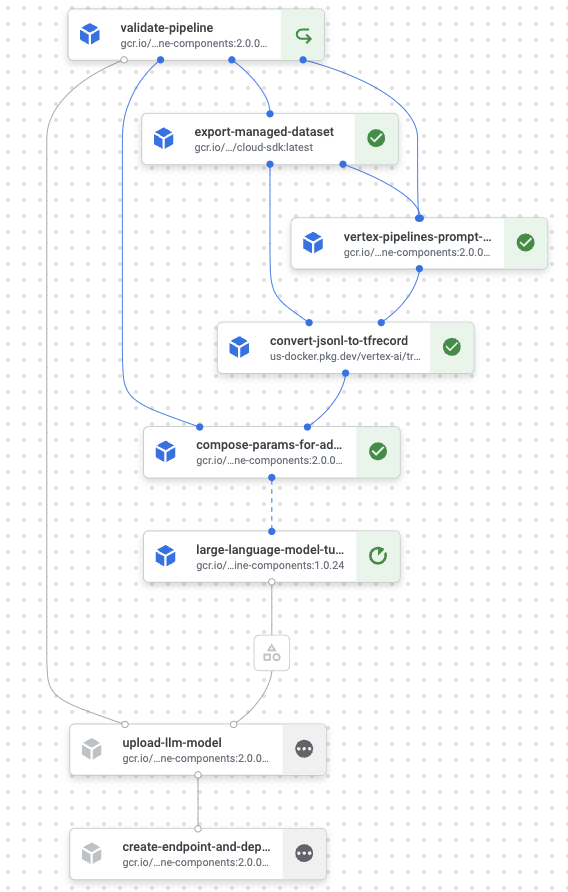

This tuning takes approximately 2 hours to run.

In [ ]:
training_data = 'gs://' + bucket_name + '/' + upload_name
train_steps = 100

vertexai.init(project=project_id, location=location)
model = TextGenerationModel.from_pretrained("text-bison@001")

model.tune_model(
  training_data=training_data,
  train_steps=train_steps,
  tuning_job_location="europe-west4",
  tuned_model_location=location,
)

To get the details of the adapter tuned model, run this command:

In [28]:
model = TextGenerationModel.from_pretrained("text-bison@001")
models = model.list_tuned_model_names()

# The first model in the list is the one we just tuned.
entity_extraction_tuned_model = models[0]
entity_extraction_tuned_model

'projects/803648085855/locations/us-central1/models/5274253924348461056'

In [35]:
def english_to_cypher_text_bison(prompt, tuned_model_name = ''):
    try:
        res = run_text_model(project_id, "text-bison@001", 0.1, 1024, 0.95, 40, prompt, location, tuned_model_name)
        return res
    except Exception as e:
        print(e)

### Generate Cypher
If you are not tuning the `text-bison` model for Cypher generation, you can consider the `code-bison` model from the Codey Models family. Let us see how to use it for Cypher generation

In [7]:
from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

def generate_code(
    api_endpoint: str,
    endpoint: str,
    input: str,
    parameters: str,
    location: str = location,
):
  # The AI Platform services require regional API endpoints.
  client_options = {"api_endpoint": api_endpoint}
  # Initialize client that will be used to create and send requests.
  # This client only needs to be created once, and can be reused for multiple requests.
  client = aiplatform.gapic.PredictionServiceClient(
      client_options=client_options
  )
  instance_dict = input
  instance = json_format.ParseDict(instance_dict, Value())
  instances = [instance]
  parameters_dict = parameters
  parameters = json_format.ParseDict(parameters_dict, Value())
  response = client.predict(
      endpoint=endpoint, instances=instances, parameters=parameters
  )
  predictions = response.predictions
  return predictions[0]["content"]

def english_to_cypher_code_bison(prompt):
    try:
        res = generate_code(f"{location}-aiplatform.googleapis.com", f"projects/{project_id}/locations/{location}/publishers/google/models/code-bison@001", {
                  "prefix": prompt
                }, {"temperature": 0, "maxOutputTokens": 2048}, location)
        return res
    except Exception as e:
        print(e)

We have to create a prompt template that clearly states what schema to use, what kind of Cypher to generate and how.

In [8]:
samples = """
Question: How many expert java developers attend more than one universities?
Answer: MATCH (p:Person)-[:HAS_SKILL]->(s:Skill), (p)-[:HAS_EDUCATION]->(e1:Education), (p)-[:HAS_EDUCATION]->(e2:Education) WHERE toLower(s.name) CONTAINS 'java' AND toLower(s.level) CONTAINS 'expert' AND e1.university <> e2.university RETURN COUNT(DISTINCT p)

Question: Where do most candidates get educated?
Answer: MATCH (p:Person)-[:HAS_EDUCATION]->(e:Education) RETURN e.university, count(e.university) as alumni ORDER BY alumni DESC LIMIT 1

Question: How many people have worked as a Data Scientist in San Francisco?
Answer: MATCH (p:Person)-[:HAS_POSITION]->(pos:Position) WHERE toLower(pos.title) CONTAINS 'data scientist' AND toLower(pos.location) CONTAINS 'san francisco' RETURN COUNT(p)
"""

In [9]:
prompt = """You are an expert Neo4j Cypher translator who understands the question in english and convert to Cypher strictly based on the Neo4j Schema provided and following the instructions below:
1. Generate Cypher query compatible ONLY for Neo4j Version 5
2. Do not use EXISTS, SIZE keywords in the cypher. Use alias when using the WITH keyword
3. Use only Nodes and relationships mentioned in the schema
4. Always enclose the Cypher output inside 3 backticks
5. Always do a case-insensitive and fuzzy search for any properties related search. Eg: to search for a Company name use `toLower(c.name) contains 'neo4j'`
6. Candidate node is synonymous to Person
7. Always use aliases to refer the node in the query
8. Cypher is NOT SQL. So, do not mix and match the syntaxes
Schema:
(:Person {label: 'Person', id: string, role: string, description: string})-[:HAS_POSITION {}]->(:Position {label: 'Position', id: string, title: string, location: string, startDate: string, endDate: string, url: string})
(:Position {label: 'Position', id: string, title: string, location: string, startDate: string, endDate: string, url: string})-[:AT_COMPANY {}]->(:Company {label:'Company', id: string, name: string})
(:Person {label: 'Person',id: string, role: string, description: string})-[:HAS_SKILL {}]->(:Skill {label:'Skill', id: string,name: string,level: string})
(:Person {label: 'Person',id: string, role: string, description: string})-[:HAS_EDUCATION {}]->(:Education {label:'Education', id: string, degree: string, university: string, graduationDate: string, score: string, url: string})
Samples:
$samples
Question: $question
Answer:
"""

In [10]:
from string import Template
que = 'How many are knowledgable on all of - java, python, javascript, security?'
_prompt = Template(prompt).substitute(samples=samples, question=que)

cypher = english_to_cypher_code_bison(_prompt) #for text-bison use: english_to_cypher_text_bison(_prompt, entity_extraction_tuned_model)
if 'Answer:\n ' in cypher:
    cypher = cypher.split('Answer:\n ')[1]
cypher = cypher.replace('\n', ' ')
cypher
    

'``` MATCH (p:Person)-[:HAS_SKILL]->(s:Skill) WHERE toLower(s.name) IN ["java", "python", "javascript", "security"] RETURN COUNT(DISTINCT p) ```'

## Talent Finder Chatbot

You can also create a chatbot that can help our interaction with Neo4j using English.

Both Vertex AI and Neo4j support LangChain.  We will be using LangChain to quickly build a chatbot that converts English to Cypher and then executes it on Neo4j.  This is augmented using generative AI before sending the response to the user.  This makes graph consumption easier for non-cypher experts. 

The diagram below shows how Neo4j and Vertex AI will interact using LangChain.

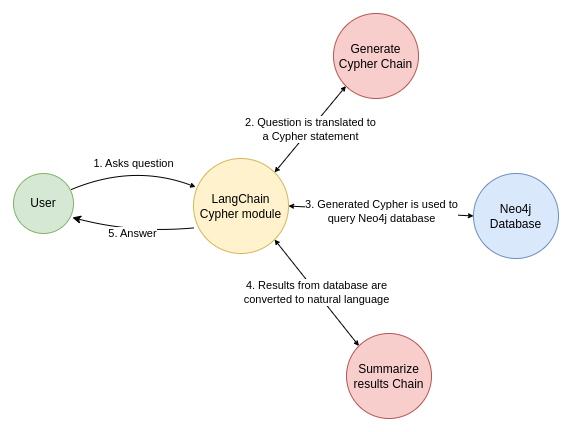

First we have to create Neo4jGraph and VertexLLM Connection objects.

In [7]:
from langchain.chains import GraphCypherQAChain
from langchain.graphs import Neo4jGraph
from langchain.llms import VertexAI
from langchain.prompts.prompt import PromptTemplate

CYPHER_GENERATION_TEMPLATE = """You are an expert Neo4j Cypher translator who understands the question in english and convert to Cypher strictly based on the Neo4j Schema provided and following the instructions below:
1. Generate Cypher query compatible ONLY for Neo4j Version 5
2. Do not use EXISTS, SIZE keywords in the cypher. Use alias when using the WITH keyword
3. Use only Nodes and relationships mentioned in the schema
4. Always enclose the Cypher output inside 3 backticks
5. Always do a case-insensitive and fuzzy search for any properties related search. Eg: to search for a Company name use `toLower(c.name) contains 'neo4j'`
6. Candidate node is synonymous to Person
7. Always use aliases to refer the node in the query
8. Cypher is NOT SQL. So, do not mix and match the syntaxes
Schema:
{schema}
Samples:
Question: How many expert java developers attend more than one universities?
Answer: MATCH (p:Person)-[:HAS_SKILL]->(s:Skill), (p)-[:HAS_EDUCATION]->(e1:Education), (p)-[:HAS_EDUCATION]->(e2:Education) WHERE toLower(s.name) CONTAINS 'java' AND toLower(s.level) CONTAINS 'expert' AND e1.university <> e2.university RETURN COUNT(DISTINCT p)
Question: Where do most candidates get educated?
Answer: MATCH (p:Person)-[:HAS_EDUCATION]->(e:Education) RETURN e.university, count(e.university) as alumni ORDER BY alumni DESC LIMIT 1
Question: How many people have worked as a Data Scientist in San Francisco?
Answer: MATCH (p:Person)-[:HAS_POSITION]->(pos:Position) WHERE toLower(pos.title) CONTAINS 'data scientist' AND toLower(pos.location) CONTAINS 'san francisco' RETURN COUNT(p)
Question: {question}
Answer:
"""
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CYPHER_GENERATION_TEMPLATE
)

graph = Neo4jGraph(
    url=connectionUrl, 
    username='neo4j', 
    password=password
)
chain = GraphCypherQAChain.from_llm(
    VertexAI(model_name='code-bison',
            max_output_tokens=2048,
            temperature=0,
            top_p=0.95,
            top_k=0.40), graph=graph, verbose=True,
            cypher_prompt=CYPHER_GENERATION_PROMPT,
    return_intermediate_steps=True
)

That's it! You can run the agent now. Simply provide the command in English. You get Cypher as output.

In [8]:
r = chain("""How many pythonistas are there?""")



> Entering new  chain...
Generated Cypher:

MATCH (p:Person)-[:HAS_SKILL]->(s:Skill) WHERE toLower(s.name) CONTAINS 'python' RETURN COUNT(p)

Full Context:
[{'COUNT(p)': 52}]

> Finished chain.


In [9]:
print(f"Intermediate steps: {r['intermediate_steps']}")
print(f"Final answer: {r['result']}")

Intermediate steps: [{'query': "\nMATCH (p:Person)-[:HAS_SKILL]->(s:Skill) WHERE toLower(s.name) CONTAINS 'python' RETURN COUNT(p)\n"}, {'context': [{'COUNT(p)': 52}]}]
Final answer: There are 52 pythonistas.


### Chatbot!
Time to build a chatbot. We will be using Gradio to quickly try out our chatbot that uses a base model. Once VertexLLM is integrated into Langchain, you will get support for adapter tuned model as well.

Running the code below will render a chat widget. You can view the Cypher generated for your input below this rendering. 

Note - Due to quota limitations, you might see errors while submitting the input. You need to wait a while in between your queries.

Some sample questions to try out:

1. How many experts do we have on MS Word?
5. Who went to most number of universities and how many did they go to?
6. Where do most candidates get educated?
7. How many people know Delphi?

In [10]:
import gradio as gr
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key = "chat_history", return_messages = True)
llm = VertexAI(model_name='code-bison',
            max_output_tokens=2048,
            temperature=0,
            top_p=0.95,
            top_k=0.40)
agent_chain = chain
def chat_response(input_text):
    response = agent_chain.run(input_text)
    return response

interface = gr.Interface(fn = chat_response, inputs = "text", outputs = "text", 
                         description = "Talent Finder Chatbot")

interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://a3585e8e5d750c37cc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)




> Entering new  chain...
Generated Cypher:

MATCH (p:Person)-[:HAS_SKILL]->(s:Skill) WHERE toLower(s.name) CONTAINS 'python' RETURN COUNT(p)

Full Context:
[{'COUNT(p)': 52}]

> Finished chain.
